## Librerias

In [60]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
import optuna
import numpy as np
import shap

scaler = RobustScaler()
le = LabelEncoder()


## Lectura del Archivo

In [34]:
fileName= "data_set_integrado_modelo_final_futuro_binario.csv"
path="../franco/"

# Read the CSV file
df = pd.read_csv(path + fileName)

In [46]:
df.info()
# df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 77 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_cotizacion                              2909 non-null   int64  
 1   id_empresa                                 2909 non-null   int64  
 2   fecha                                      2909 non-null   object 
 3   precio_apertura                            2909 non-null   float64
 4   precio_cierre                              2909 non-null   float64
 5   precio_max                                 2909 non-null   float64
 6   precio_min                                 2909 non-null   float64
 7   volumen_operado                            2909 non-null   float64
 8   variacion_porcentaje                       2862 non-null   float64
 9   nombre                                     2909 non-null   object 
 10  label                   

Codificacion de Variables Categoricas

In [36]:
df['label_t_plus_1_encoded'] = le.fit_transform(df['label_t_plus_1'])  # SUBE=1, NO_SUBE=0

Normalización de Features Numéricas **(opcional para LightGBM)**

In [37]:
features_numericas = ['precio_cierre', 'volumen_operado', 'suma_score_sentimiento_positivas']
df[features_numericas] = scaler.fit_transform(df[features_numericas])

Selecciono FEATURES claves

In [38]:
features = [
    # Precios y volumen
    'precio_cierre', 'volumen_operado', 'precio_cierre_lag_1', 'precio_cierre_media_5d', 
    'precio_cierre_std_5d', 'variacion_porcentaje',
    
    # Sentimiento
    'suma_score_sentimiento_positivas', 'ratio_sent_positivo_negativo', 
    'suma_score_sentimiento_positivas_lag_1',
    
    # Temporales
    'dia_semana', 'es_fin_de_mes',
    
    # Tendencias
    'tendencia_precio_5d', 'diff_score_sentimiento'
]
target = 'label_t_plus_1_encoded'

# Modelado de Lightgbm

In [39]:
train_size = int(0.8 * len(df))
X_train, X_test = df[features][:train_size], df[features][train_size:]
y_train, y_test = df[target][:train_size], df[target][train_size:]

In [44]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'dart',
    'num_leaves': 40,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1
}

model = lgb.LGBMClassifier(**params)

# Entrenamos usando callbacks en lugar de early_stopping_rounds directo
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),   # detiene si no mejora en 50 iter
        lgb.log_evaluation(period=10)             # imprime log cada 10 iter
    ]
)

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.67685
[20]	valid_0's binary_logloss: 0.668527
[30]	valid_0's binary_logloss: 0.664071
[40]	valid_0's binary_logloss: 0.663072
[50]	valid_0's binary_logloss: 0.662905
[60]	valid_0's binary_logloss: 0.665483
[70]	valid_0's binary_logloss: 0.666317
[80]	valid_0's binary_logloss: 0.663764
[90]	valid_0's binary_logloss: 0.663512
[100]	valid_0's binary_logloss: 0.662264


LGBMClassifier(bagging_fraction=0.7, boosting_type='dart', feature_fraction=0.8,
               lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.05,
               metric='binary_logloss', num_leaves=40, objective='binary',
               verbose=-1)

## Evaluacion

In [47]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")

Accuracy: 0.58
F1-Score: 0.53


## Optimizacion de hiperparametros con OPTUNA

In [50]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    return f1_score(y_test, model.predict(X_test))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-05-03 10:50:44,309] A new study created in memory with name: no-name-9162082b-2749-4459-aa7f-d032a412958d
[I 2025-05-03 10:50:44,841] Trial 0 finished with value: 0.5204460966542751 and parameters: {'num_leaves': 21, 'learning_rate': 0.20480265678833237, 'feature_fraction': 0.7400284486797187, 'lambda_l1': 2.1981562410747966}. Best is trial 0 with value: 0.5204460966542751.
[I 2025-05-03 10:50:45,295] Trial 1 finished with value: 0.5220588235294118 and parameters: {'num_leaves': 76, 'learning_rate': 0.10658371392880706, 'feature_fraction': 0.8719464221292175, 'lambda_l1': 2.507800232273765}. Best is trial 1 with value: 0.5220588235294118.
[I 2025-05-03 10:50:45,762] Trial 2 finished with value: 0.5397412199630314 and parameters: {'num_leaves': 72, 'learning_rate': 0.18731670586839663, 'feature_fraction': 0.7709104415152013, 'lambda_l1': 0.07665455072761562}. Best is trial 2 with value: 0.5397412199630314.
[I 2025-05-03 10:50:46,010] Trial 3 finished with value: 0.50561797752808

# Interpretacion con SHAP (Shapley Additive Explanations)
Esta libreria es un marco teorico que se utiliza para explicar el resultado de cualquier modelo de ML.

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


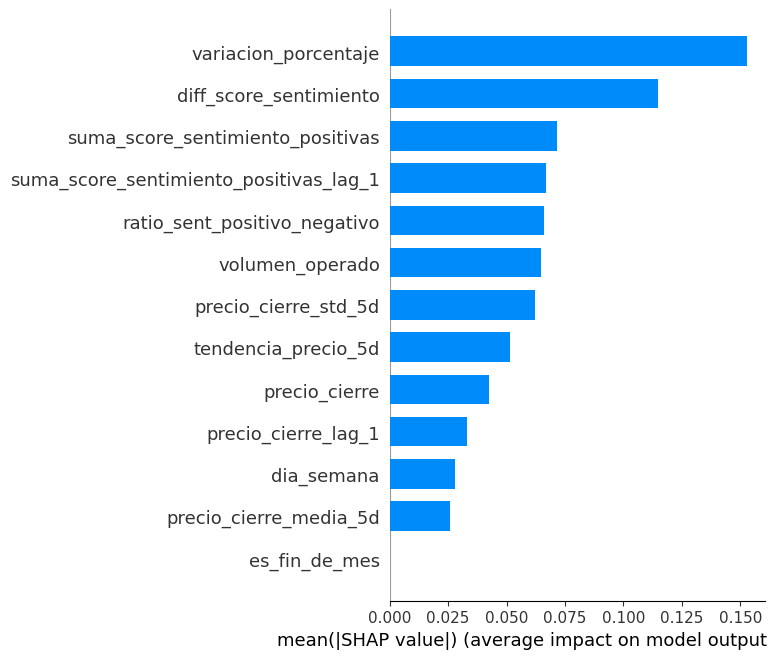

In [54]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualización de importancia
shap.summary_plot(shap_values, X_test, plot_type="bar")

Backtesting Básico

In [59]:
df_test = df.iloc[train_size:].copy()
df_test['prediccion'] = model.predict_proba(X_test)[:, 1]  # Probabilidad de SUBE

# Estrategia simple: Comprar si probabilidad > 0.6
df_test['decision'] = np.where(df_test['prediccion'] > 0.6, 1, 0)
df_test['retorno_estrategia'] = df_test['decision'] * df_test['variacion_porcentaje'].shift(-1)

print(f"Retorno acumulado: {df_test['retorno_estrategia'].sum():.2f}%")

Retorno acumulado: 64.83%
